In [1]:
import time, sys, math, copy
import numpy as np
from matplotlib import pyplot as plt 

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import import_ipynb
from MoveData import Options, json2datatools, num_batches, nopeak_mask, create_masks
%matplotlib inline

importing Jupyter notebook from MoveData.ipynb


If you are not using this notebook to learn, change the below variable `teaching` to `False` so that other notebooks can import the functions defined in this notebook without running all the examples, if you are here to learn and interact with the notebook, change it to `True`

In [2]:
teaching = False # True 

Before going into this lesson, lets remind ourselves where the components we are about to learn fit into the big picture. Recall the overall architecture of the Transformer. It is useful to image yourself as a piece of data, then imagine the journey you are about to go on. 

Imagine you emerge from the `data_iter` function as a sequence of integers shaped (batch size, sequence length)

T.he first place you will go is the encoder. It is initialized using `self.encoder = Encoder(in_vocab_size, emb_dim, n_layers, heads, dropout)` and used in the form `e_output = self.encoder(src_seq, src_mask)`. 

In [3]:
class Transformer(nn.Module):
    def __init__(self, in_vocab_size, out_vocab_size, emb_dim, n_layers, heads, dropout):
        super().__init__()
        self.encoder = Encoder(in_vocab_size, emb_dim, n_layers, heads, dropout)
        self.decoder = Decoder(out_vocab_size, emb_dim, n_layers, heads, dropout)
        self.out = nn.Linear(emb_dim, out_vocab_size)
    def forward(self, src_seq, trg_seq, src_mask, trg_mask):
        e_output = self.encoder(src_seq, src_mask)
        d_output = self.decoder(trg_seq, e_output, src_mask, trg_mask)
        output = self.out(d_output)
        return output

The first component, or module, within the Encoder, is the Embedder. emb_dim is short for embedding_dimensions

`self.embed = Embedder(vocab_size, embedding_dimensions)` 

`x = self.embed(source_sequence)`

In [4]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, n_layers, heads, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.embed = Embedder(vocab_size, emb_dim)
        self.pe = PositionalEncoder(emb_dim, dropout=dropout)
        self.layers = get_clones(EncoderLayer(emb_dim, heads, dropout), n_layers)
        self.norm = Norm(emb_dim)
    def forward(self, src_seq, mask):
        x = self.embed(src_seq)
        x = self.pe(x)
        for i in range(self.n_layers):
            x = self.layers[i](x, mask)
        x = self.norm(x)
        return x

## Embedding

What is Embedding? As we mentioned before, one ability, or limitation depending on how you look at it, of chloe is her fixed vocabulary, each word or symbol in her vocabulary is assigned an integer. For example the word hi is assigned 3, the word dog is 17, a word not in the vocabulary is 0. This integer is the `token` index. 

The neural nework sees every word as a vector. [A vector of 3 real numbers forms the coordinates in 3D space](https://youtu.be/fNk_zzaMoSs). We use several more dimensions than 3 in deep learning, if we use 512 dimensions, our `embedding_dimensions = 512`, this means that each word is a point in 512 dimensional space. The same concepts apply to 3D space in that the location of that word in 3D space tells you it's [meaning and meaning relative to other words](https://youtu.be/8rXD5-xhemo?t=1550).

<img src="../saved/images/wordvectors.png" height=400 width=400>

In the image you see above, similar words are close to each other, not only that, the direction they are separated from eachother also carries meaning. In the image, there are 3 clusters of words and the separation between them has something to do with age/time/etc.  

If you stack all the vectors on top of eachother row by row, you get a matrix. Remember how each word is represented by both a vector and an integer? well this integer is the index for a row in the matrix. The matrix is called the embedding matrix. you might say that we "embed" words into the matrix. Now for the example, run the cells below 

In [5]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.embed = nn.Embedding(vocab_size, emb_dim)
    def forward(self, x):
        return self.embed(x)

To demonstrate the Embedder, I will show you it's two functions

- storing an embedding matrix of word vectors 
- transforming a sequence of integers that represent token indices, into a sequence of vectors

Lets start off by creating a toy embedding with only 2 tokens in it. These tokens will be represented in 4-dimensional space. The data comes to us as a sequence of integers. 

After creating the embedding, I pass into the Embedder a sequence of token indices, the integers `[1,0,1]` created by this line `source_sequence = torch.from_numpy(np.asarray([1,0,1])).unsqueeze(0)`, the ending `.unsqueeze(0)` adds a batch dimension and thus turns the shape of the input from `[3,]` to `[1,3]`. The information in the tensor is the same, The embedder just requires it's input to be of shape (batch_size, sequence_length)

In [6]:
if teaching:  
    torch.manual_seed(0)
    embedding = Embedder(vocab_size=2, emb_dim=4)
    source_sequence = torch.from_numpy(np.asarray([1,0,1])).unsqueeze(0)
    print('source_sequence',source_sequence, source_sequence.shape)
    print("---------------------------------------------------")
    print("Embedding Matrix", embedding.embed.weight, embedding.embed.weight.shape)
    print("---------------------------------------------------")
    sequence_of_vectors = embedding(source_sequence)
    print('sequence_of_vectors',sequence_of_vectors, sequence_of_vectors.shape)

source_sequence tensor([[1, 0, 1]]) torch.Size([1, 3])
---------------------------------------------------
Embedding Matrix Parameter containing:
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380]], requires_grad=True) torch.Size([2, 4])
---------------------------------------------------
sequence_of_vectors tensor([[[-1.0845, -1.3986,  0.4033,  0.8380],
         [ 1.5410, -0.2934, -2.1788,  0.5684],
         [-1.0845, -1.3986,  0.4033,  0.8380]]], grad_fn=<EmbeddingBackward>) torch.Size([1, 3, 4])


## Embedding Matrix

Suppose, as I mentioned earlier, I am unhappy with chloe's limited vocabulary `{"me":0, "give":1}`. I want her to learn the word "covfefe". I will have to add a word to her dictionary `{"covfefe":2}` (not shown), then I will have to initialize a new word vector and add it, concatenate it, to chloe's embedding matrix `embedding.embed.weight`. In the cell below, I do just that. 

`concatenated_matrix` is the concatenation of the old matrix `embedding.embed.weight` with the `new_vector` appended to the bottom row. Now we can embed our

sequence of integers **(batch_size, sequence_length)** 

into a vector sequence for the phrase "give me covfefe"


In [7]:
if teaching:  
    np.random.seed(0)
    new_vector = torch.from_numpy(np.random.uniform(-0.1,0.1,(1, 4)).astype(np.float32))
    print('new_vector', new_vector, new_vector.shape)
    print("---------------------------------------------------")
    concatenated_matrix = torch.cat((embedding.embed.weight, new_vector),dim=0)
    embedding.embed.weight=nn.Parameter(concatenated_matrix,requires_grad=True)
    print("New Embedding Matrix", embedding.embed.weight, embedding.embed.weight.shape)
    print("---------------------------------------------------")
    source_sequence = torch.from_numpy(np.asarray([1,0,2])).unsqueeze(0)
    print('source_sequence',source_sequence, source_sequence.shape)
    print("---------------------------------------------------")
    sequence_of_vectors = embedding(source_sequence)
    print('sequence_of_vectors',sequence_of_vectors, sequence_of_vectors.shape)

new_vector tensor([[0.0098, 0.0430, 0.0206, 0.0090]]) torch.Size([1, 4])
---------------------------------------------------
New Embedding Matrix Parameter containing:
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380],
        [ 0.0098,  0.0430,  0.0206,  0.0090]], requires_grad=True) torch.Size([3, 4])
---------------------------------------------------
source_sequence tensor([[1, 0, 2]]) torch.Size([1, 3])
---------------------------------------------------
sequence_of_vectors tensor([[[-1.0845, -1.3986,  0.4033,  0.8380],
         [ 1.5410, -0.2934, -2.1788,  0.5684],
         [ 0.0098,  0.0430,  0.0206,  0.0090]]], grad_fn=<EmbeddingBackward>) torch.Size([1, 3, 4])


## Positional Encoding

I find it useful to jeep track of the shape of my data as it goes on it's journey through the neural network

After the embedding, the shape is this vector sequence is

**(batch_size, sequence_length, embedding_dimensions)**

`[[-1.0845, -1.3986,  0.4033,  0.8380]`  give

` [ 1.5410, -0.2934, -2.1788,  0.5684 ]`  me

` [ 0.0098,  0.0430,  0.0206,  0.0090]]` covfefe
  
The next step is positional encoding. Imagine that the correct response to the above input 
is "heres your covfefe". This response makes sense given the input only in the order "give me covfefe". If I were to mix them up and say " me give covfefe", you might think that I was about to give you some covfefe, and that I was some sort of caveman. The other popular sequence models are the recurrent neural network (RNN) family of models, these models process the input vectors in chronological order, starting with "give", ending with "covfefe", updating a hidden state at each timestep. The RNN Decoder likewise continues to modify the hidden state as it predicts the output tokens. Transformers on the other hand pay attention to all inputs at each output step. So unless we bake into the vectors some information about it's position in the sequence (first, second, 6th, last, etc), the Transformer will be dealing with essentially a bag of words. 

The paper [Attention is all you need](https://arxiv.org/abs/1706.03762) writes:

"Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension `dmodel` as the embeddings, so that the two can be summed. There are many choices of positional encodings,learned and fixed. In this work, we use sine and cosine functions of different frequencies:
 
 $$\text{PE}(pos,2i)=sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
 
 $$\text{PE}(pos,2i+1)=cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
 
where pos is the position and i is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000·2π. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, $$PE_{pos+k}$$ can be represented as a linear function of $$PE_{pos}$$ 

We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training."

Below is their Positional Encoder in PyTorch built to take in our shape **(batch_size, sequence_length, embedding_dimensions)** sequence of vectors

In [8]:
class PositionalEncoder(nn.Module):

    def __init__(self, emb_dim, max_seq_len = 200, dropout = 0.1):
        super().__init__()
        self. emb_dim =  emb_dim
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on pos and i
        # this matrix of shape (1, input_seq_len, emb_dim) is
        # cut down to shape (1, input_seq_len, emb_dim) int he forward pass
        # to be broadcasted across each sampel in the batch 
        pe = torch.zeros(max_seq_len, emb_dim)
        for pos in range(max_seq_len):
            for i in range(0, emb_dim, 2):
                wavelength = 10000 ** ((2 * i)/ emb_dim)
                pe[pos, i] = math.sin(pos / wavelength)
                pe[pos, i + 1] = math.cos(pos / wavelength)
        pe = pe.unsqueeze(0) #add a batch dimention to your pe matrix 
        self.register_buffer('pe', pe) #block of data(persistent buffer)->temporary memory
 
    def forward(self, x):
        '''
        input: sequence of vectors  
               shape (batch size, input sequence length, vector dimentions)
        output: sequence of vectors of same shape as input with positional
                aka time encoding added to each sample 
                shape (batch size, input sequence length, vector dimentions)
        '''
        x = x * math.sqrt(self. emb_dim) # make embeddings relatively larger
        seq_len = x.size(1)
        pe = Variable(self.pe[:,:seq_len], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe #add constant to embedding
        return self.dropout(x)

Lets take for example the vector for "covfefe" and call it:

$$ e_{w} = [ 0.0098,  0.0430,  0.0206,  0.0090] $$

The version of our "covfefe" vector with the time encoding added to it looks like:

$$ e_{w}' =  e_{w} + PostionalEncoding = PostionallyEncodedVector$$

Since our vector has only 4 dimensionts, we have positional encoder for 4 dimensions with only 2 iterations of i, this is i = 0 and i = 1, since for each value i, we get positional encoding for 2i and 2i+1.

2(0)=0, 2(0)+1 = 1, 2(1)=2, 2(1)+1=3

Accoring to the formula above, each of the 2i positions use sine and each of the 2i+1 use cosine, giving us the formula below for how to add a 4 dimensional positional encoding for any given postion *pos*

$$\begin{align*}e_{w}'&= e_{w} + \left[sin\left(\frac{pos}{10000^{2(0)/4}}\right), cos\left(\frac{pos}{10000^{2(0)/4}}\right),sin\left(\frac{pos}{10000^{2(1)/4}}\right),cos\left(\frac{pos}{10000^{2(1)/4}}\right)\right]\\
&= e_{w} + \left[sin\left(\frac{pos}{10000^{0}}\right), cos\left(\frac{pos}{10000^{0}}\right),sin\left(\frac{pos}{10000^{2/4}}\right),cos\left(\frac{pos}{10000^{2/4}}\right)\right]\\
&=e_{w} + \left[sin\left(pos\right), cos\left(pos\right),sin\left(\frac{pos}{100}\right),cos\left(\frac{pos}{100}\right)\right]\\
\end{align*}$$

for pos = 1, we get 

$$e_{w}=e_{w} + [0,1,0,1]$$

Look at the first row (first postion) of the positional encoding matrix `positioner.pe[:,:seq_len]` you should see a matching `[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00]`

In [9]:
if teaching: 
    seq_len = sequence_of_vectors.size(1)
    positioner = PositionalEncoder(emb_dim=4, max_seq_len=100, dropout=0.0) 
    print(positioner.pe.shape)
    print('seq_len',seq_len)
    print(positioner.pe[:,:seq_len])

torch.Size([1, 100, 4])
seq_len 3
tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  1.0000e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  2.0000e-04,  1.0000e+00]]])


Another way to look at this is that our encoding [0,1,0,1] is the first column of values in the graph below

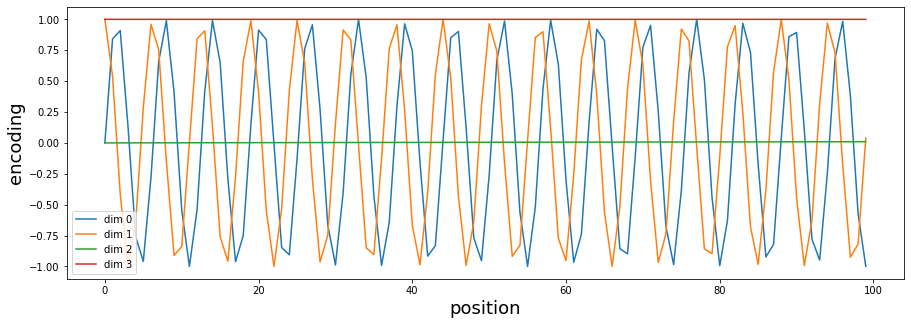

In [10]:
if teaching: 
    plt.figure(figsize=(15, 5)) 
    y = positioner(Variable(torch.zeros(1, 100, 4))) 
    plt.plot(np.arange(100), y[0, :, :].data.numpy())
    plt.xlabel('position', fontsize=18)
    plt.ylabel('encoding', fontsize=18)
    plt.legend(["dim %d"%p for p in [0,1,2,3]])

When studying Transformers, the part I found most confusing was Positional Encoding. Why it works. The reason is elaborated in
[this Blog by  Lennart Van der Goten](http://vandergoten.ai/2018-09-18-attention-is-all-you-need/)

Below is a modified diagram from tha blog that shows how each positon gets a unique encoding added to it. Above we use an abnormally small 4 dimensions, below you see the range of encodings than are added to a arbitrarily longer choice of dimensions for d_model, aka emb_dim.

<img src="../saved/images/positionalencoding.png">

Now lets add the positional encoding to our sequence

In [11]:
if teaching:  
    print('sequence_of_vectors',sequence_of_vectors, sequence_of_vectors.shape) 
    print("---------------------------------------------------")
    sequence_of_vectors = positioner(sequence_of_vectors)
    print(sequence_of_vectors, sequence_of_vectors.shape)
    print("---------------------------------------------------")

sequence_of_vectors tensor([[[-1.0845, -1.3986,  0.4033,  0.8380],
         [ 1.5410, -0.2934, -2.1788,  0.5684],
         [ 0.0098,  0.0430,  0.0206,  0.0090]]], grad_fn=<EmbeddingBackward>) torch.Size([1, 3, 4])
---------------------------------------------------
tensor([[[-2.1690, -1.7972,  0.8067,  2.6761],
         [ 3.9235, -0.0466, -4.3575,  2.1369],
         [ 0.9288, -0.3301,  0.0413,  1.0180]]], grad_fn=<AddBackward0>) torch.Size([1, 3, 4])
---------------------------------------------------


## repeating modules with nn.ModuleList

`get_clones()` allows us to stack the same module N number of times. The data would thus pass through multiple modules of the same repeating architecture. To be clear, the weights would be NOT be shared though, each module is allowed to compute something different. 

FeedForward is a vanilla feed forward neural network that as the same dimensions for it's input as for it's output. If you need a brush up on vanilla feed forward neural networks, I suggest []() or [Welch Labs](https://youtu.be/bxe2T-V8XRs) or [3Blue1Brown](https://youtu.be/aircAruvnKk). One small modification I made here is using the leaky_relu rather than relu activation function. 

In [12]:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class FeedForward(nn.Module):
    def __init__(self, emb_dim, ff_dim=2048, dropout = 0.1):
        super().__init__() 
    
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(emb_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(ff_dim, emb_dim)
    
    def forward(self, x, explain=False):
        x = self.dropout(F.leaky_relu(self.linear_1(x)))
        if explain: print('hidden layer output',x)
        x = self.linear_2(x)
        return x

`self.linear_1 = nn.Linear(emb_dim, ff_dim)` creates one fully connected layer. Dropout is not a layer, it is simply a way to add robustness to the neural network by randomly zeroing out the outputs of one layer and proportionally scaling up the remainder of the outputs. This forces the next layer to not spread out it's dependence on the previous layers outputs rather than rely too heavily on a few of the previous layers dimensions.

The cell below recreates the feed forward neural network (FFNN) depicted in this diagram having an input of dimension 4, a hidden layer with output of dimension 5, and output of dimension 4.

<img src="../saved/images/feedforward.png">

With `explain=True` as an argument to the forward method of the FeedForward modules that is initiated with a dropout of 0.2, you would expect on average 1 of the 5 hidden layer outputs to be zeroed out to `0.0000` each time you run the forward pass. Run the next cell a couple times to observe this. 

In [13]:
if teaching:  
    FFNN = FeedForward(emb_dim = 4, ff_dim=5, dropout = 0.2)
    x = torch.from_numpy(np.asarray([.01,-.01,.01,-.01])).float().unsqueeze(0)
    print('output',FFNN(x, explain=True))

hidden layer output tensor([[-0.0037,  0.5284,  0.2887,  0.0000,  0.0000]], grad_fn=<MulBackward0>)
output tensor([[ 0.1001, -0.1847,  0.2447, -0.0275]], grad_fn=<AddmmBackward>)


Since the input and output dimensions of FeedForward are the same, I can stack any number of them repeatedly together to create an arbitrarily deep neural network. The cell below demonstrates this by demonstrating the use of the `get_clones()` funtion.

In [14]:
class repeatFeedForward(nn.Module):
    def __init__(self, repeats):
        super().__init__()
        self.repeats = repeats
        self.layers = get_clones(FeedForward(emb_dim=4, ff_dim=5, dropout=0.2), repeats)
    def forward(self, x, explain=True):
        for i in range(self.repeats):
            x = self.layers[i](x, explain=explain)
        return x

In [15]:
if teaching:  
    rFFNN = repeatFeedForward(repeats=3)
    x = torch.from_numpy(np.asarray([.01,-.01,.01,-.01])).float().unsqueeze(0)
    print('output',rFFNN(x, explain=True))

hidden layer output tensor([[-0.0000, -0.0029,  0.2470, -0.0000,  0.0000]], grad_fn=<MulBackward0>)
hidden layer output tensor([[ 0.0000, -0.0000,  0.0922, -0.0027,  0.6105]], grad_fn=<MulBackward0>)
hidden layer output tensor([[ 0.0000, -0.0000,  0.2158, -0.0047,  0.3337]], grad_fn=<MulBackward0>)
output tensor([[ 0.2067, -0.2059,  0.3808,  0.2397]], grad_fn=<AddmmBackward>)


## Normalization (Standardizing)

This concept is easier to teach in the domain of computer vision. The same concept applies to computer language. In both cases, the data are represented in vector space and both can benefit from normalization. 

Imagine you train a neural network to recognise pictures of your cat in your house. Then you try to test if it works and you realize that because all your training data was taken during the day, it doesnt recognize your cat as well during the evening, probably because the lighting is different. 

Thats because if you take one image that the model has learnt well and shift/scale the input features, the parameters are no longer optimal for this shift/scaled image. We normalize the input image to be between 0 and 1 or between -1 and 1 or a unit gaussian so that our first layer can learn faster by focusing on learning the variation within images rather than the variation between images.

This same intuition applies not just to the input. Since each layers output is another representation of the data and serves as the input to the next layer, this intuition applies to all the intermediate representations as well. 

In [16]:
class Norm(nn.Module):
    def __init__(self, emb_dim, eps = 1e-6):
        super().__init__()
        self.size = emb_dim
        # alpha and bias are learnable parameters that scale and shift
        # the representations respectively, aka stretch and translate 
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps #prevents divide by zero explosions 
    
    def forward(self, x):
        '''
        input: x, shape (batch size, sequence length, embedding dimensions)
        output: norm, shape (batch size, sequence length, embedding dimensions)
        '''
        norm = (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps)
        norm = self.alpha * norm + self.bias
        return norm

In the image below, we take whatever the mean is mu and standard devation is sigma, and make it into a unit gaussian aka “standard normal” distribution.

<img src="https://miro.medium.com/max/744/1*GAcEj37smCOCZMrqp-rjjA.png">

The demo below uses a toy input of shape `[2, 2, 3]`, simulating a batch with 2 samples, 2 words in sequence length, and a embedding dimension of 3. 

The tensor above `x.mean(dim=-1, keepdim=True)` calculates the mean of each word vector and the tensor above `x.std(dim=-1, keepdim=True)` calculates the standard deviation of each word vector

If we make the simplifying assumption that our vector `x` follows a Gaussian distribution. We can subtract the mean and divide by the standard deviation, thereby obtaining a “standard normal” distribution, with mean 0 and standard deviation 1.


In [17]:
if teaching:
    x = np.asarray([ [[0.0, 1.0, 2.0], [2.0, 3.0, 4.0]], [[1.0, 2.0, 3.0], [3.0, 4.0, 5.0]]  ])
    x = torch.from_numpy(x).float()
    print(x, x.shape)
    print("------------------------------------")
    print(x.mean(dim=-1, keepdim=True))
    print("------------------------------------")
    print(x.std(dim=-1, keepdim=True))

tensor([[[0., 1., 2.],
         [2., 3., 4.]],

        [[1., 2., 3.],
         [3., 4., 5.]]]) torch.Size([2, 2, 3])
------------------------------------
tensor([[[1.],
         [3.]],

        [[2.],
         [4.]]])
------------------------------------
tensor([[[1.],
         [1.]],

        [[1.],
         [1.]]])


## Attention 

The `MultiHeadAttention()` module takes in a sequence of vectors and outputs a sequence of vectors of teh same shape. What it does to the sequence is modify each vector in such a way that it takes into account, to different degrees, the other vectors in the sequence. 

Consider the all the different meanings of the word "date", spelled the same way

- Her favorite fruit is a date.
- Carson took Vicki out on a date.
- Not to date myself, but I remember listening to cassette tapes.
- 10/26/19, thats the date of our wedding

The only way for you to know which of these meanings the word "date" is being used as, is by using the the other words in the sentence, ie the context. 

For every word in the sentence, the authors of the Transformer came up with the "attention head". Here is one example from the paper [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) of how one head is using the other words to modify the representation of the word "it's"

<img src="../saved/images/onehead.png">

Several heads are used, to allow different types of attention, the image below shows 3 types of attention for different relationships between words "who", " Did what?" and "To whom?"

<img src="../saved/images/multihead.png">

Each attention head works the same way, by transforming each vector in the sequence into another vector space. Those vectors are q, k and v, meaning the query, key and value vectors. Where the dot product between the "it's" query vector and the "law" key vector is proportional to the strength of the attention between "it's" and "law"

[Jay Alammar](http://jalammar.github.io/illustrated-transformer/) does an excellent job in illustrating this in in his blog:

Alammar, Jay (2018). The Illustrated Transformer [Blog post]. Retrieved from https://jalammar.github.io/illustrated-transformer/

He uses the example source sequence <font color='green'>"Thinking Machines"</font> represented by the 2x4 matrix <font color='green'>X</font>. 2x4 because there are 2 words, each word represented by a 4 dimensional vector. The q, k and v vectors are each 3 dimensional. 

Going from x to q occurs by doing a matrix multiplication. If X is shape (2x4), you can use a matrix W of shape (4x3) to transform X to a matrix <font color='purple'>Q</font> of shape (2x3) Each row q is for one of the 2 words. Instead of running a for loop through all the heads, it is better to "vectorize" your operations for computational efficiency, by concatenating all your W's together. In the example below we have 3 heads, so instead of doing 3 seprate matrix multiplications with a transofrmation matrix (4x3) we use one large matrix shape (4x9) and slice our heads out of the longer matrix later

<img src="../saved/images/qkvmatrix.png">

in the code below, the operation in the image is represented by the code 

`q = self.q_linear(q)`

`k = self.k_linear(k)`

`v = self.v_linear(v)`

In [26]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, emb_dim, dim_k = None, dropout = 0.1):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.dim_k = dim_k if dim_k else emb_dim // num_heads
        self.num_heads = num_heads
        self.q_linear = nn.Linear(emb_dim,self.dim_k*num_heads)
        self.k_linear = nn.Linear(emb_dim,self.dim_k*num_heads)
        self.v_linear = nn.Linear(emb_dim,self.dim_k*num_heads)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(self.dim_k*num_heads,emb_dim)
    
    def attention(self, q, k, v, dim_k, mask=None, dropout=None, explain=False):
        k = k.transpose(-2, -1)
        if explain: print('q, k', q.shape, k.shape)
        # matrix multiplication is done using the last two dimensions
        # (batch_size,num_heads,q_seq_len,dim_k)X(batch_size,num_heads,dim_k,k_seq_len)
        #(batch_size,num_heads,q_seq_len,k_seq_len)
        scores = torch.matmul(q, k) / math.sqrt(dim_k) 
        if explain: print('scores.shape', scores.shape)
        if mask is not None:
            mask = mask.unsqueeze(1)
            if explain: print('mask.shape', mask.shape)
            scores = scores.masked_fill(mask == 0, -1e9) 
        softscores = F.softmax(scores, dim=-1)
        if dropout is not None: softscores = dropout(softscores)
            
        #(batch_size,num_heads,q_seq_len, k_seq_len)X(batch_size,num_heads,v_seq_len,dim_v)
        output = torch.matmul(softscores, v)
        return output, scores #=(batch_size,num_heads,q_seq_len,dim_v)
    
    def forward(self, q, k, v, mask=None, explain=False):
        '''
        inputs:
            q has shape (batch size, q_sequence length, embedding dimensions)
            k,v are shape (batch size, kv_sequence length, embedding dimensions)
            source_mask of shape (batch size, 1, kv_sequence length)
        outputs: sequence of vectors, re-represented using attention
            shape (batch size, q_sequence length, embedding dimensions)
        use:
            The encoder layer places the same source vector sequence into q,k,v 
            and source_mask into mask.
            The decoder layer uses this twice, once with decoder inputs as q,k,v 
            and target mask as mask. then with decoder inputs as q, encoder outputs
            as k, v and source mask as mask
        '''
        # k,q,v are each shape (batch size, sequence length, dim_k * num_heads)
        batch_size = q.size(0)
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        if explain: print("(batch size, sequence length, dim_k * num_heads)", k.shape)
        # k,q,v are each shape (batch size, sequence length, num_heads, dim_k)
        k = k.view(batch_size,-1,self.num_heads,self.dim_k)
        q = q.view(batch_size,-1,self.num_heads,self.dim_k)
        v = v.view(batch_size,-1,self.num_heads,self.dim_k)
        # transpose to shape (batch_size, num_heads, sequence length, dim_k)
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        if explain: print("(batch_size,num_heads,seq_length,dim_k)",k.shape)
        # calculate attention using function we will define next
        attn, scores = self.attention(q, k, v, self.dim_k, mask, self.dropout, explain)
        if explain: print("attn(batch_size,num_heads,seq_length,dim_k)", attn.shape)
        # concatenate heads, dim_k = dim_v
        concat=attn.transpose(1,2).contiguous().view(batch_size,-1,self.dim_k*self.num_heads)
        if explain: print("concat.shape", concat.shape)
        # put through final linear layer
        output = self.out(concat)
        if explain: print("MultiHeadAttention output.shape", output.shape)
        return output, scores

The key and query vectors are dot producted with each other, so dim_q == dim_k, we will just call it dim_qk

In the forward method of MultiHeadAttention above, the `view()` and `transpose()` operations serve to [re-arrange](https://discuss.pytorch.org/t/tensor-view-is-misleading/20553) the matrices q, k, into the shape **(batch_size, num_heads ,seq_len, dim_qk)**  

The last two dimensions of `k` are transposed by the line `k = k.transpose(-2, -1)` such that `k` is reshaped to  **(batch_size, num_heads , dim_qk, seq_len)**

The reason for this is so that in the attention function we can accomplish the dot product operation through matrix multiplication in the line ` scores = torch.matmul(q, k) / math.sqrt(dim_k)`. PyTorch's matmul operation, performs matrix multiplication on the last two dimensions of our tensors.  We are essentially performing the matrix multiplication <font color='purple'>query (q_seq_len, dim_qk)</font> X <font color='orange'>key (dim_qk, k_seq_len)</font> =<font color='red'> score matrix (q_seq_len, k_seq_len)</font> for every sample in the batch and for every head. 

We have saved ourselves from having to implement 2 for loops. 

<img src="../saved/images/scorematrix.png">

In `scores = F.softmax(scores, dim=-1)` a <font color='red'> softmax </font> is applied such that each row sums to 1.0 (red matrix)

In the line  `output = torch.matmul(scores, v)` we are essentilly performing the operations of shape <font color='red'>score matrix (q_seq_len, k_seq_len)</font> X <font color='lightblue'>values (v_seq_len, dim_v)</font> = <font color='blue'>context values (v_seq_len, dim_v)</font> for every sample in the batch and for every head. 
The sequence length of the keys and values must be the same but dont have to match the sequence length of the query. 

<img src="../saved/images/contextmatrix.png">

One way to interpret the first row of the score matrix is that it is saying 

"rebalance the word 'Thinking' by taking 80% of the magnitude of 'Thinking' and add it to 20% of the value of 'Machines'"

`concat=attn.transpose(1,2).contiguous().view(batch_size,-1,self.dim_k*self.num_heads)` reshapes the tensor by concatenating all the values from each head to make a tensor shape (batch size, sequence length, dim_v*num_heads)

`output = self.out(concat)` uses a matrix multiplication to tranform each dim_v word vector to one of the same size as the embedding dimensions. The result is that the shape of the attention output is the same as the input. 
(batch size, sequence length, embedding dimensions)

The demo below uses a toy input of shape `[2, 3, 5]`, simulating a batch with 2 samples, 3 words in sequence length, and a embedding dimension of 5. We pretend that the last word in the first sample is a padding vector and is therefore masked out. 

In [19]:
if teaching:
    input_vectors = np.asarray([ 
                    [[0.0, 0.0, 0.1, 0.2, 0.3],[0.0, 0.1, 0.2, 0.3, 0.4],[0.0, 0.2, 0.3, 0.4, 0.5]], 
                    [[0.0, 0.1, 0.2, 0.3, 0.4],[0.0, 0.2, 0.3, 0.4, 0.5],[0.0, 0.3, 0.4, 0.5, 0.6]]  
                               ])

    input_mask = torch.from_numpy(np.ones((2,1,3)) == 1)
    input_mask[0,0,-1] = False
    input_vectors = torch.from_numpy(input_vectors).float()

    print('input_vectors shape \n', input_vectors.shape)
    print('---------------------------------------')
    print('input_mask \n', input_mask, input_mask.shape)
    print('---------------------------------------')

input_vectors shape 
 torch.Size([2, 3, 5])
---------------------------------------
input_mask 
 tensor([[[ True,  True, False]],

        [[ True,  True,  True]]]) torch.Size([2, 1, 3])
---------------------------------------


In [20]:
if teaching:
    multiattention = MultiHeadAttention(num_heads=6,emb_dim=5,dim_k=4,dropout=0.0)
    output, scores = multiattention(input_vectors,input_vectors,input_vectors,input_mask,explain=True)

(batch size, sequence length, dim_k * num_heads) torch.Size([2, 3, 24])
(batch_size,num_heads,seq_length,dim_k) torch.Size([2, 6, 3, 4])
q, k torch.Size([2, 6, 3, 4]) torch.Size([2, 6, 4, 3])
scores.shape torch.Size([2, 6, 3, 3])
attn(batch_size,num_heads,seq_length,dim_k) torch.Size([2, 6, 3, 4])
concat.shape torch.Size([2, 3, 24])
MultiHeadAttention output.shape torch.Size([2, 3, 5])


## Masks and Softmax
The last thing to cover in the `MultiHeadAttention()` function is the way the mask is applied to the attention scores and the way the softmax is applied to the attention scores. 

In intuitive words, imagine that the first sample is `thinking machines <pad>`. We dont need to incorporate the token `<pad>` into the representation of "thinking" or "machines" so our mask for this sequence is `[ True,  True, False]`.
In the case of the decoder output, the mask depends on what step in the output we are in. Each output can only attend to the previous outputs so the mask will look something like `[ True]` for the first step and `[ True,  True, True, False]` for the 3rd step etc. This is more relevant for training but not for inference. 

The mask is reshaped into (batch size, 1, 1, sequence length) in the case of the source mask, and (batch size, 1, sequence length, sequence length) in the case of the target mask.

This is [broadcasted](https://medium.com/ai%C2%B3-theory-practice-business/understanding-broadcasting-in-pytorch-ca9e9533f05f) across the scores which are of shape (batch size, number of heads, sequence length, sequence length). Broadcasting will apply the mask across each row of the (sequence length x sequence length) matrix. Think of each row as the being assigned to each token. The first row is for the token "thinking". If this row looks something like `[2.0, 0.1, -100]`, it means that the word "thinking" should be defined mostly by it's own token `2.0`, alittle by the word "machines" `0.1`, and practically not at all by the padding token `-100`. The code `scores = scores.masked_fill(mask == 0, -1e9)` takes the very negative value, `-1e9` and replaces the score values at equivalent position where the mask has `False` or `0` as it's element, with this very negative value `-1.0000e+09`. 

`softscores = F.softmax(scores, dim=-1)` will then rebalance each row such that they all sum to 1.0, `dim=-1` means the last dimension. Think of a matrix that has 2 rows and 3 columns, it is a 2 x 3 matrix. If you softmax across the last dimension of size 3, you are making all 3 of those sum to 1.0 

In the cell below we demonstrate what we have discussed by running the attention function without the mask, getting the unmasked score and applying the mask to the score step by step for demonstration

In [ ]:
if teaching:
    output, scores = multiattention(input_vectors,input_vectors,input_vectors,explain=False)
    print(input_mask, input_mask.shape, scores.shape)
    print(scores[0,0,:,:])
    print(scores[1,0,:,:])
    print("------------------------------------------------------")
    mask = input_mask.unsqueeze(1)
    print(mask, mask.shape, scores.shape)
    scores = scores.masked_fill(mask == 0, -1e9) 
    print(scores[0,0,:,:])
    print(scores[1,0,:,:])
    print("------------------------------------------------------")
    softscores = F.softmax(scores, dim=-1)
    print(softscores[0,0,:,:])
    print(softscores[1,0,:,:])

Wow, that was alot to cover. I am giving you a high five for getting through all this. You have now learned the building blocks of the Transformer. The rest of the transformer is taking these LEGO pieces and assembling them. Go to Encoder.ipynb for the next lesson

## How can I help you or get help from you?

[Support *ChloeRobotics* on Patreon and send us a message](https://www.patreon.com/chloerobotics)

## Questions?

email chloe.the.robot [at] gmail [dot] com 